
# YOLOv2
> Darknet-19 + Passthrough(reorg) + Anchor 기반 YOLOv2 구현

**Pipeline**
1. 환경 체크 & 설정
2. 데이터셋 unzip → JSON 라벨 파싱 (bbox: x,y,w,h)
3. 클래스 자동 생성, 데이터 통계
4. K-means로 앵커(5개) 추정 (IoU distance)
5. YOLOv2 모델(Darknet-19 유사 + passthrough) 구현
6. 손실 함수(YOLOv2 스타일) 구현
7. 학습/검증 루프
8. 추론 및 시각화 (NMS 포함)


## 1) 환경 체크 & 기본 설정

In [20]:
# (선택) GPU 체크
import torch, os, sys, math, random, json, zipfile, pathlib, time, shutil
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models import resnet18
import torchvision.models as models
import torchvision
from torchvision import models, transforms
import torch.optim as optim
import cv2
from pathlib import Path

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

PyTorch: 2.8.0+cu126
CUDA available: True


device(type='cuda')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2) 경로 설정 & 데이터셋 Unzip

In [3]:
# pathlib 라이브러리에서 Path 객체 불러오기 (경로를 객체처럼 다룰 수 있음)
from pathlib import Path

# 탐색할 경로 리스트 (drawings.zip 이 있는 위치를 미리 지정)
zip_candidates = [Path("/content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/picture.zip")]

# 실제 사용할 zip 경로 변수 (아직 없음)
zip_path = None

# 존재하는 파일을 찾으면 zip_path에 할당
for c in zip_candidates:
    if c.exists():
        zip_path = c
        break

# zip_path를 못 찾으면 에러 발생
if zip_path is None:
    raise FileNotFoundError("picture.zip 파일을 찾을 수 없습니다. 업로드 또는 경로 확인!")
print("Using zip:", zip_path)

# 압축 해제할 루트 폴더 지정 (./data)
root = Path("./data")

# 기존 폴더가 있으면 삭제 (재실행 대비)
if root.exists():
    print("기존 추출 폴더 삭제:", root)
    shutil.rmtree(root)

# data 폴더 새로 생성
root.mkdir(parents=True, exist_ok=True)

# zipfile 라이브러리로 압축 해제
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(root) # ./data 폴더에 압축 풀기

print("Extracted to:", root)

# 추출한 폴더 내부에서 "01.원천데이터" 폴더 찾기
src_dir = next(root.glob("**/01.원천데이터"))
# 추출한 폴더 내부에서 "02.라벨링데이터" 폴더 찾기
lbl_dir = next(root.glob("**/02.라벨링데이터"))

print("원천:", src_dir)
print("라벨:", lbl_dir)

# 이미지 확장자 모음 (이미지 필터링에 사용)
IMG_EXTS = {".jpg",".jpeg",".png",".bmp"}

Using zip: /content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/picture.zip
Extracted to: data
원천: data/Sample/01.원천데이터
라벨: data/Sample/02.라벨링데이터


## 3) 라벨 파싱: 클래스/박스 통계

In [4]:
from collections import defaultdict, Counter
from PIL import Image

# JSON 라벨 파일을 파싱하는 함수
def parse_json(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        d = json.load(f) # JSON 로드
    meta = d.get("meta", {}) # 이미지 메타데이터 (경로, 해상도 등)
    ann = d.get("annotations", {}) # 어노테이션 정보
    bboxes = ann.get("bbox", []) # 바운딩박스 리스트 (x,y,w,h,label 포함)
    img_rel = meta.get("img_path") # 이미지 상대 경로
    # JSON 파일 위치 기준으로 실제 이미지 절대 경로 생성
    img_path = (Path(json_path).parent / Path(img_rel)).resolve()
    img_path = Path(str(img_path)).resolve()
    return {
        "img_path": img_path, # 이미지 실제 경로
        "bboxes": bboxes,  # [{x,y,w,h,label} ...]
        "img_resolution": meta.get("img_resolution",""), # 해상도 정보 (없으면 빈 문자열)
        "class": ann.get("class",""), # 전체 클래스 이름 (없으면 빈 문자열)
    }

# 이미지 크기를 (width, height) 형태로 반환
def image_size(path):
    try:
        with Image.open(path) as im:
            return im.size # (W, H)
    except Exception:
        return None # 이미지가 깨졌거나 없으면 None 반환

# 라벨 JSON 파일 리스트 수집
json_list = sorted([p for p in lbl_dir.rglob("*.json")])
print("라벨 파일 수:", len(json_list))

items = [] # 최종 이미지 + 어노테이션 모음
label_counter = Counter() # 라벨별 개수를 세기 위한 Counter

for jp in json_list:
    info = parse_json(jp) # JSON 파싱
    if not info["img_path"].exists(): # 이미지 파일이 실제로 없으면
        cand = list(src_dir.rglob(info["img_path"].name)) # 원천데이터에서 이름으로 재검색
        if cand:
            info["img_path"] = cand[0] # 발견 시 해당 경로로 교체
        else:
            continue # 이미지 못 찾으면 스킵
    # 바운딩박스 안의 라벨들을 세기
    for bb in info["bboxes"]:
        label_counter[bb.get("label","UNKNOWN")] += 1
    items.append(info) # 유효 데이터만 리스트에 추가

print("유효 이미지 수:", len(items))
print("라벨 분포 상위 20개:", label_counter.most_common(20))

# 클래스 인덱싱 (클래스명 <-> 숫자 ID 매핑)
classes = sorted(label_counter.keys()) # 전체 클래스 정렬
cls2idx = {c:i for i,c in enumerate(classes)} # 클래스명 → 인덱스
idx2cls = {i:c for c,i in cls2idx.items()} # 인덱스 → 클래스명
num_classes = len(classes)
print("총 클래스 수:", num_classes)
print("예시 클래스:", classes[:20])

# 앞 20장 이미지 크기 확인
sizes = []
for it in items[:20]:
    sizes.append(image_size(it["img_path"]))
print("앞 20장 크기 샘플:", sizes[:5])

라벨 파일 수: 560
유효 이미지 수: 560
라벨 분포 상위 20개: [('꽃', 637), ('눈', 560), ('팔', 560), ('발', 560), ('운동화', 560), ('다리', 559), ('귀', 557), ('손', 557), ('잔디', 525), ('주머니', 517), ('나뭇잎', 509), ('별', 485), ('열매', 477), ('단추', 290), ('사람전체', 280), ('머리', 280), ('얼굴', 280), ('코', 280), ('입', 280), ('머리카락', 280)]
총 클래스 수: 47
예시 클래스: ['가지', '구름', '굴뚝', '귀', '그네', '기둥', '길', '꽃', '나무', '나무전체', '나뭇잎', '남자구두', '눈', '다람쥐', '다리', '단추', '달', '머리', '머리카락', '목']
앞 20장 크기 샘플: [(1280, 1280), (1280, 1280), (1280, 1280), (1280, 1280), (1280, 1280)]


## 4) K-means로 Anchor 5개 추정

In [5]:
# YOLO 입력 이미지 크기 (416x416)
INPUT_SIZE = 416
# anchor 개수 (클러스터 개수)
K = 5

whs = [] # 바운딩박스의 (width, height) 비율 저장 리스트
for it in items:
    sz = image_size(it["img_path"]) # 이미지 크기 가져오기
    if sz is None:
        continue
    w_img, h_img = sz
    for bb in it["bboxes"]:
        # 바운딩박스의 w,h를 이미지 크기로 나누어 정규화 (0~1 범위)
        bw = bb["w"]/w_img
        bh = bb["h"]/h_img
        if bw>0 and bh>0: # 유효한 박스만 저장
            whs.append([bw,bh])
whs = np.array(whs, dtype=np.float32)
print("수집 박스 수:", len(whs))

# (w,h) 기반 IOU 계산 함수
def bbox_iou_wh(box, centers):
    w,h = box
    ww = centers[:,0]; hh=centers[:,1]
    inter = np.minimum(w,ww)*np.minimum(h,hh) # 교집합 면적
    union = w*h + ww*hh - inter + 1e-9 # 합집합 면적
    return inter/union # IOU 값 반환

# K-means 기반 anchor box 추출 함수
def kmeans_anchors(data, k=5, seed=42, iters=100):
    n = data.shape[0]
    np.random.seed(seed)
    # 초기 중심값 무작위 선택
    centers = data[np.random.choice(n, k, replace=False)].copy()
    for _ in range(iters):
        # --- assign 단계 ---
        assign = []
        for i in range(n):
            ious = bbox_iou_wh(data[i], centers) # 각 박스와 중심들의 IOU
            assign.append(int(np.argmax(ious))) # IOU가 가장 큰 중심에 할당
        assign = np.array(assign)

        # --- update 단계 ---
        new_centers = []
        for j in range(k):
            pts = data[assign==j] # 클러스터에 속한 박스들
            if len(pts)==0:
                # 비어있으면 임의의 박스를 다시 선택
                new_centers.append(data[np.random.randint(0,n)])
            else:
                # 중앙값(median)을 새 중심으로 업데이트
                new_centers.append(np.median(pts, axis=0))
        new_centers = np.array(new_centers)

        # 중심이 변하지 않으면 종료
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    return centers

# 실제로 anchor 추출 (데이터 충분하면 kmeans 실행)
if len(whs) >= K:
    anchors_wh = kmeans_anchors(whs, k=K)
else:
    # 데이터가 부족할 경우 기본 anchor 값 사용
    anchors_wh = np.array([[0.04,0.05],[0.1,0.12],[0.12,0.19],[0.23,0.12],[0.26,0.25]], dtype=np.float32)

# anchor 비율을 실제 입력 크기(416)로 변환
anchors_px = (anchors_wh * INPUT_SIZE).astype(np.float32)
print("Anchors (ratio):\n", anchors_wh) # 정규화된 비율
print("Anchors (px @416):\n", anchors_px) # 416 입력 크기 기준 px 단위


수집 박스 수: 13822
Anchors (ratio):
 [[0.02265625 0.02421875]
 [0.35546875 0.3265625 ]
 [0.07421875 0.07421875]
 [0.146875   0.159375  ]
 [0.04140625 0.04453125]]
Anchors (px @416):
 [[  9.425     10.075   ]
 [147.875    135.84999 ]
 [ 30.875     30.875   ]
 [ 61.1       66.299995]
 [ 17.225     18.525   ]]


## 5) 데이터셋 & 전처리

In [6]:
import random
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import torch

# YOLO grid 설정
GRID_SIZE = 13
STRIDE = INPUT_SIZE // GRID_SIZE  # 416/13 = 32 → 하나의 grid cell 크기

# letterbox: 비율 유지한 resize 후 여백 채우기 (YOLO에서 자주 사용)
def letterbox(im: Image.Image, new_size=INPUT_SIZE, color=(114,114,114)):
    w,h = im.size
    scale = min(new_size/w, new_size/h) # 가로/세로 비율 중 작은 쪽에 맞춰 축소
    nw, nh = int(w*scale), int(h*scale) # 축소된 크기
    im_resized = im.resize((nw,nh), Image.BILINEAR)  # 축소
    canvas = Image.new('RGB', (new_size,new_size), color) # 빈 배경 생성
    pad_x = (new_size - nw)//2
    pad_y = (new_size - nh)//2
    canvas.paste(im_resized, (pad_x, pad_y)) # 중앙에 배치
    return canvas, scale, pad_x, pad_y

# 색상/밝기 증강 (HSV augmentation)
def augment_hsv(im: Image.Image, hgain=0.015, sgain=0.7, vgain=0.4):
    s_factor = 1 + (random.random()*2-1)*sgain
    v_factor = 1 + (random.random()*2-1)*vgain
    im = ImageEnhance.Color(im).enhance(s_factor) # 채도 변화
    im = ImageEnhance.Brightness(im).enhance(v_factor) # 밝기 변화
    return im

# 수평 반전 augmentation
def random_hflip(im: Image.Image, boxes):
    if random.random()<0.5:
        w,h = im.size
        im = ImageOps.mirror(im) # 좌우 반전
        nboxes = []
        for x,y,bw,bh,cls_id in boxes:
            nx = w - (x + bw) # 반전된 좌표 계산
            nboxes.append([nx,y,bw,bh,cls_id])
        return im, nboxes
    return im, boxes

# target tensor 빌드 (YOLO ground truth format)
def build_target_tensor(boxes, anchors, num_classes, grid_size=GRID_SIZE, img_size=INPUT_SIZE):
    target = np.zeros((grid_size, grid_size, anchors.shape[0], 5 + num_classes), dtype=np.float32)
    for (x,y,w,h,cls) in boxes:
        cx, cy = x + w/2, y + h/2 # 바운딩박스 중심 좌표
        gx, gy = int(cx//STRIDE), int(cy//STRIDE) # 해당 box가 속하는 grid cell
        if not(0 <= gx < grid_size and 0 <= gy < grid_size):
            continue
        gt = np.array([w,h], dtype=np.float32)

        # anchor 선택 (wh 기준 IOU 최대인 anchor)
        ious = []
        for a in anchors:
            inter = np.minimum(gt[0], a[0]) * np.minimum(gt[1], a[1])
            union = gt[0]*gt[1] + a[0]*a[1] - inter + 1e-9
            ious.append(inter/union)
        aidx = int(np.argmax(ious)) # 가장 IOU 큰 anchor 선택
        aw, ah = anchors[aidx]

        # 좌표 변환 (YOLO format)
        cx_cell = (cx/STRIDE) - gx
        cy_cell = (cy/STRIDE) - gy
        tx, ty = cx_cell, cy_cell
        tw = np.log((w/(aw+1e-9))+1e-9)
        th = np.log((h/(ah+1e-9))+1e-9)

        # target tensor 채우기
        target[gy,gx,aidx,0]=tx
        target[gy,gx,aidx,1]=ty
        target[gy,gx,aidx,2]=tw
        target[gy,gx,aidx,3]=th
        target[gy,gx,aidx,4]=1.0  # objectness
        target[gy,gx,aidx,5+cls]=1.0 # one-hot class
    return target

# --- Dataset 클래스 정의 ---
class DrawingsYOLODataset(torch.utils.data.Dataset):
    def __init__(self, items, cls2idx, input_size=INPUT_SIZE, anchors_px=None, augment=True):
        self.items = items
        self.cls2idx = cls2idx
        self.input_size = input_size
        self.anchors = np.array(anchors_px, dtype=np.float32)
        self.augment = augment
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        info = self.items[idx]
        im = Image.open(info["img_path"]).convert("RGB") # 이미지 로드
        boxes = []
        # json에서 바운딩박스 읽기
        for bb in info["bboxes"]:
            x,y,w,h = bb["x"], bb["y"], bb["w"], bb["h"]
            cls_id = self.cls2idx.get(bb.get("label",""), -1)
            if cls_id<0 or w<=0 or h<=0: continue
            boxes.append([x,y,w,h,cls_id])
        # augmentation
        if self.augment:
            im, boxes = random_hflip(im, boxes)
            im = augment_hsv(im)
        # letterbox resize
        im_lb, scale, pad_x, pad_y = letterbox(im, self.input_size)
        # resize/패딩된 좌표로 보정
        nboxes = []
        for x,y,w,h,cls_id in boxes:
            x = x*scale + pad_x; y = y*scale + pad_y
            w = w*scale; h = h*scale
            nboxes.append([x,y,w,h,cls_id])
        # target tensor 생성
        target = build_target_tensor(nboxes, self.anchors, num_classes=len(self.cls2idx))
        # 이미지 → [C,H,W] tensor
        arr = np.array(im_lb).astype(np.float32)/255.0
        arr = np.transpose(arr,(2,0,1))
        img = torch.from_numpy(arr)
        tgt = torch.from_numpy(target)
        return img, tgt

# collate_fn: dataloader가 batch 구성할 때 사용
def collate_fn(b):
    imgs = torch.stack([x[0] for x in b])
    tgts = torch.stack([x[1] for x in b])
    return imgs, tgts

# --- 데이터 분할 ---
random.seed(42)
perm = list(range(len(items)))
random.shuffle(perm)
n_train = int(len(perm)*0.9)  # 90% train, 10% val
train_idx, val_idx = perm[:n_train], perm[n_train:]
train_items = [items[i] for i in train_idx]
val_items = [items[i] for i in val_idx]

# Dataset 생성
train_ds = DrawingsYOLODataset(train_items, cls2idx, INPUT_SIZE, anchors_px, augment=True)
val_ds   = DrawingsYOLODataset(val_items, cls2idx, INPUT_SIZE, anchors_px, augment=False)

# DataLoader 생성
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

# 데이터셋 크기 확인
len(train_ds), len(val_ds)


(504, 56)

## 6) YOLOv2 모델 (Darknet-19 유사 + Passthrough)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Conv → BN → LeakyReLU 블록 (YOLO에서 반복적으로 사용)
def conv_bn_leaky(c_in, c_out, k=3, s=1, p=None):
    if p is None: p = (k-1)//2 # 기본 padding: same
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, k, s, p, bias=False), # Conv
        nn.BatchNorm2d(c_out), # BatchNorm
        nn.LeakyReLU(0.1, inplace=True) # LeakyReLU(0.1)
    )

# YOLOv2의 Backbone: Darknet-19
class Darknet19(nn.Module):
    # 416x416 입력 → 13x13 feature
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            conv_bn_leaky(3,32,3,1),
            nn.MaxPool2d(2,2),  # 416 → 208
        )
        self.layer2 = nn.Sequential(
            conv_bn_leaky(32,64,3,1),
            nn.MaxPool2d(2,2),  # 208 → 104
        )
        self.layer3 = nn.Sequential(
            conv_bn_leaky(64,128,3,1),
            conv_bn_leaky(128,64,1,1),
            conv_bn_leaky(64,128,3,1),
            nn.MaxPool2d(2,2),  # 104 → 52
        )
        self.layer4 = nn.Sequential(
            conv_bn_leaky(128,256,3,1),
            conv_bn_leaky(256,128,1,1),
            conv_bn_leaky(128,256,3,1),
            nn.MaxPool2d(2,2),   # 52 → 26
        )
        self.layer5 = nn.Sequential(
            conv_bn_leaky(256,512,3,1),
            conv_bn_leaky(512,256,1,1),
            conv_bn_leaky(256,512,3,1),
            conv_bn_leaky(512,256,1,1),
            conv_bn_leaky(256,512,3,1),
        )  # 26x26 feature map
        self.maxpool5 = nn.MaxPool2d(2,2) # 26 → 13
        self.layer6 = nn.Sequential(
            conv_bn_leaky(512,1024,3,1),
            conv_bn_leaky(1024,512,1,1),
            conv_bn_leaky(512,1024,3,1),
            conv_bn_leaky(1024,512,1,1),
            conv_bn_leaky(512,1024,3,1),
        )  # 최종 13x13 feature map

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        route = self.layer5(x)    # 26x26 feature (passthrough 용)
        x = self.maxpool5(route)  # 13x13
        x = self.layer6(x)        # 13x13
        return route, x # (26x26, 13x13) 둘 다 반환

# Reorg Layer (YOLOv2 passthrough connection)
# stride=2 → 26x26 feature → 13x13로 줄이면서 채널 수 4배 증가
class Reorg(nn.Module):
    def __init__(self, stride=2):
        super().__init__()
        self.stride = stride
    def forward(self, x):
        B,C,H,W = x.shape
        s = self.stride
        assert H%s==0 and W%s==0
        # (B, C, H//s, s, W//s, s) → (B, C*s*s, H//s, W//s)
        x = x.view(B, C, H//s, s, W//s, s).permute(0,1,3,5,2,4).contiguous()
        x = x.view(B, C*s*s, H//s, W//s)
        return x

# YOLOv2 Head
class YOLOv2(nn.Module):
    def __init__(self, num_classes, anchors, grid_size=13):
        super().__init__()
        self.num_classes = num_classes
        self.K = anchors.shape[0] # anchor 개수
        self.S = grid_size  # grid 크기
        self.anchors = torch.tensor(anchors, dtype=torch.float32) # anchor 리스트
        self.backbone = Darknet19() # feature extractor (Darknet19)
        self.passthrough_conv = conv_bn_leaky(512,64,1,1,0) # 26x26 → 채널 축소
        self.reorg = Reorg(2) # 26x26 → 13x13, 채널 4배
        self.head = nn.Sequential(
            conv_bn_leaky(1024 + 64*4, 1024, 3,1), # concat 후 conv
            nn.Conv2d(1024, self.K*(5+num_classes), 1,1,0) # 최종 예측
        )
    def forward(self, x):
        route26, x13 = self.backbone(x) # backbone 출력
        p = self.passthrough_conv(route26) # 26x26 conv
        p = self.reorg(p) # 26x26 → 13x13 (채널 증가)
        x = torch.cat([x13, p], dim=1) # skip connection concat
        out = self.head(x)  # (B, K*(5+C), 13, 13)
        B,C,H,W = out.shape
        # (B, 13, 13, K, 5+C) 로 reshape
        out = out.permute(0,2,3,1).contiguous().view(B, H, W, self.K, 5+self.num_classes)
        return out

## 7) 손실 함수

In [8]:
import torch.nn.functional as F

class YOLOv2Loss(nn.Module):
    def __init__(self, anchors, num_classes, lambda_coord=6.0, lambda_noobj=0.5, iou_ignore=0.5): # lambda_coord = 5.0 에서 6.0으로 변경
        """
        개선 반영:
          1) tx, ty에 sigmoid 적용 후 MSE
          2) noobj ignore 마스크 (예측-모든 GT 최대 IoU > thresh 인 위치는 noobj 손실에서 제외)
          3) positive의 objectness 타깃 = 예측-해당 GT IoU (detach)
        """
        super().__init__()
        # anchor box 크기 (px 단위)
        self.anchors = torch.tensor(anchors, dtype=torch.float32)  # (K,2) in px@416
        self.num_classes = num_classes
        # 논문에서 사용된 손실 가중치
        self.lambda_coord = lambda_coord # 좌표 손실 가중치 (기본 5)
        self.lambda_noobj = lambda_noobj # noobj 손실 가중치 (기본 0.5)
        self.iou_ignore = iou_ignore  # noobj 무시 임계값(기본 0.5)

    def _xyxy_iou_pairwise(self, a, b):
        """
        a: (Na,4), b:(Nb,4)  -> IoU (Na,Nb)
        """
        if b.numel() == 0:
            return a.new_zeros((a.shape[0], 0))
        ax1, ay1, ax2, ay2 = a[:,0:1], a[:,1:2], a[:,2:3], a[:,3:4]
        bx1, by1, bx2, by2 = b[:,0].unsqueeze(0), b[:,1].unsqueeze(0), b[:,2].unsqueeze(0), b[:,3].unsqueeze(0)

        inter_x1 = torch.maximum(ax1, bx1)
        inter_y1 = torch.maximum(ay1, by1)
        inter_x2 = torch.minimum(ax2, bx2)
        inter_y2 = torch.minimum(ay2, by2)
        iw = (inter_x2 - inter_x1).clamp(min=0)
        ih = (inter_y2 - inter_y1).clamp(min=0)
        inter = iw * ih

        area_a = (ax2 - ax1).clamp(min=0) * (ay2 - ay1).clamp(min=0)
        area_b = (bx2 - bx1).clamp(min=0) * (by2 - by1).clamp(min=0)
        union = area_a + area_b - inter + 1e-9
        return inter / union

    def _xyxy_iou_elementwise(self, a, b):
        """
        a,b: (N,4) -> IoU(N,)  (같은 인덱스끼리 IoU)
        """
        ax1, ay1, ax2, ay2 = a[:,0], a[:,1], a[:,2], a[:,3]
        bx1, by1, bx2, by2 = b[:,0], b[:,1], b[:,2], b[:,3]
        inter_x1 = torch.maximum(ax1, bx1)
        inter_y1 = torch.maximum(ay1, by1)
        inter_x2 = torch.minimum(ax2, bx2)
        inter_y2 = torch.minimum(ay2, by2)
        iw = (inter_x2 - inter_x1).clamp(min=0)
        ih = (inter_y2 - inter_y1).clamp(min=0)
        inter = iw * ih
        area_a = (ax2 - ax1).clamp(min=0) * (ay2 - ay1).clamp(min=0)
        area_b = (bx2 - bx1).clamp(min=0) * (by2 - by1).clamp(min=0)
        union = area_a + area_b - inter + 1e-9
        return inter / union

    def forward(self, pred, target):
        """
        pred   : (B, S, S, K, 5+C) raw
        target : (B, S, S, K, 5+C) (tx,ty,tw,th,obj, one-hot class)
        """
        device = pred.device
        B, S, _, K, _ = pred.shape
        anchors = self.anchors.to(device)  # (K,2)

        # --- 분해 ---
        p_tx, p_ty = pred[...,0], pred[...,1]
        p_tw, p_th = pred[...,2], pred[...,3]
        p_to      = pred[...,4]
        p_cls     = pred[...,5:]

        t_tx, t_ty = target[...,0], target[...,1]
        t_tw, t_th = target[...,2], target[...,3]
        t_to       = target[...,4]
        t_cls      = target[...,5:]

        obj   = t_to                # 1/0
        noobj = 1.0 - obj

        # ===== 1) 좌표 손실: tx,ty에 sigmoid 적용 후 MSE =====
        p_tx_sig = torch.sigmoid(p_tx)
        p_ty_sig = torch.sigmoid(p_ty)
        pos_mask = obj.bool()
        if pos_mask.any():
            l_tx = F.mse_loss(p_tx_sig[pos_mask], t_tx[pos_mask], reduction='mean')
            l_ty = F.mse_loss(p_ty_sig[pos_mask], t_ty[pos_mask], reduction='mean')
            l_tw = F.mse_loss(p_tw[pos_mask], t_tw[pos_mask], reduction='mean')
            l_th = F.mse_loss(p_th[pos_mask], t_th[pos_mask], reduction='mean')
            l_coord = l_tx + l_ty + l_tw + l_th
        else:
            l_coord = torch.tensor(0.0, device=device)
        # ===== 디코딩(예측/GT) → IoU 계산용 =====
        # stride: 416 / S (전역 INPUT_SIZE를 쓰되, 없으면 32로 폴백)
        try:
            stride = float(INPUT_SIZE) / float(S)
        except NameError:
            stride = 32.0

        # grid (S,S,K)
        gx = torch.arange(S, device=device).view(1, S).repeat(S, 1)
        gy = torch.arange(S, device=device).view(S, 1).repeat(1, S)
        grid_x = gx.unsqueeze(-1).repeat(1, 1, K).float()
        grid_y = gy.unsqueeze(-1).repeat(1, 1, K).float()

        # anchors (1,1,K)
        aw = anchors[:,0].view(1,1,K)
        ah = anchors[:,1].view(1,1,K)

        # 예측 박스 디코딩 (cx,cy,w,h) → (x1,y1,x2,y2)
        pred_cx = (p_tx_sig + grid_x) * stride
        pred_cy = (p_ty_sig + grid_y) * stride
        pred_w  = aw * torch.exp(p_tw)
        pred_h  = ah * torch.exp(p_th)
        pred_x1 = pred_cx - pred_w/2
        pred_y1 = pred_cy - pred_h/2
        pred_x2 = pred_cx + pred_w/2
        pred_y2 = pred_cy + pred_h/2

        # GT 박스 디코딩 (tx,ty는 이미 0~1 오프셋)
        gt_cx = (t_tx + grid_x) * stride
        gt_cy = (t_ty + grid_y) * stride
        gt_w  = aw * torch.exp(t_tw)
        gt_h  = ah * torch.exp(t_th)
        gt_x1 = gt_cx - gt_w/2
        gt_y1 = gt_cy - gt_h/2
        gt_x2 = gt_cx + gt_w/2
        gt_y2 = gt_cy + gt_h/2

        # 펼치기 (B, S,S,K,4)
        pred_xyxy = torch.stack([pred_x1, pred_y1, pred_x2, pred_y2], dim=-1)
        gt_xyxy   = torch.stack([gt_x1,   gt_y1,   gt_x2,   gt_y2  ], dim=-1)

        # ===== 2) noobj ignore 마스크 생성 =====
        # 각 배치별로 "모든 예측" vs "해당 배치의 모든 GT( obj==1 )" 최대 IoU 계산
        max_iou = torch.zeros((B, S, S, K), device=device)
        for b in range(B):
            gt_mask_b = obj[b].bool()                        # (S,S,K)
            if gt_mask_b.any():
                gt_b = gt_xyxy[b][gt_mask_b]                 # (M,4)
                pred_b = pred_xyxy[b].reshape(-1, 4)         # (S*S*K,4)
                ious_b = self._xyxy_iou_pairwise(pred_b, gt_b)   # (S*S*K, M)
                max_iou_b = ious_b.max(dim=1).values.reshape(S, S, K)
                max_iou[b] = max_iou_b
            # else: 그대로 0

        ignore_mask = (max_iou > self.iou_ignore)  # (B,S,S,K) , self.iou_ignore 대신 상수(0.4 ~ 0.5) 적용하여 배경 손실 감소 1) 0.5 에서 0.4로 더 내림
        eff_noobj = (~obj.bool()) & (~ignore_mask)

        # ===== 3) objectness 타깃을 IoU로 =====
        # positive 위치에서: pred vs 해당 GT의 IoU를 타깃으로 사용 (detach)
        pos_mask = obj.bool()
        if pos_mask.any():
            pred_pos = pred_xyxy[pos_mask]                   # (Npos,4)
            gt_pos   = gt_xyxy[pos_mask]                     # (Npos,4)  - 같은 인덱스의 GT
            iou_pos  = self._xyxy_iou_elementwise(pred_pos, gt_pos).detach().clamp(0,1)
            l_obj = F.binary_cross_entropy_with_logits(p_to[pos_mask], iou_pos, reduction='mean') # sum에서 mean으로 바꿔서 배치 크기 변화에 덜 민감하게
        else:
            l_obj = torch.tensor(0.0, device=device)

        if eff_noobj.any():
            l_noobj = F.binary_cross_entropy_with_logits(p_to[eff_noobj], torch.zeros_like(p_to[eff_noobj]), reduction='sum')
        else:
            l_noobj = torch.tensor(0.0, device=device)

        # l_conf = l_obj + self.lambda_noobj * l_noobj -> YOLO v1 방식에서
        # l_conf = F.binary_cross_entropy_with_logits(
        #     p_conf, obj.float(), reduction="none"
        # )
        # l_conf = (l_conf * ignore_mask).mean() # YOLO v2 방식으로 변경

        # ===== 클래스 손실 (obj 위치에서만) =====
        if self.num_classes > 1 and pos_mask.any():
            smooth = 0.05 # 개선 : label smoothing → 오버피팅 완화 1) 0.1에서 0.05
            t_cls_smoothed = t_cls[pos_mask] * (1 - smooth) + smooth / self.num_classes # → 기존 one-hot에 살짝 균등 확률을 섞어서 과적합 완화
            # soft target 대응이 필요하면 KL divergence 사용 가능
            l_cls = F.kl_div(F.log_softmax(p_cls[pos_mask], dim=-1), t_cls_smoothed, reduction='batchmean') # → soft target(부드러운 라벨)과 예측 분포의 KL divergence 계산
        else:
            l_cls = torch.tensor(0.0, device=device)

            # 기존 cross-entropy 대신 KL divergence + label smoothing로 교체

        # 최종 손실
        loss = (
            self.lambda_coord * l_coord +
            l_obj +
            self.lambda_noobj * l_noobj +
            l_cls
        )

        return loss, {
            "coord": l_coord.item(),
            "obj": l_obj.item(),
            "noobj": l_noobj.item(),
            "cls": l_cls.item(),
            "total": loss.item()
        }


## 8) 학습 / 검증

In [12]:
from tqdm import tqdm

# 모델/손실/최적화기 정의
model = YOLOv2(num_classes=num_classes, anchors=anchors_px, grid_size=GRID_SIZE).to(DEVICE)
criterion = YOLOv2Loss(anchors=anchors_px, num_classes=num_classes, iou_ignore=0.5).to(DEVICE)

classifier = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
classifier.fc = nn.Linear(classifier.fc.in_features, num_classes)
classifier = classifier.to(DEVICE)

cls_transform = transforms.Compose([
    transforms.Resize((224,224)),  # Tensor도 처리 가능
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

LEARNING_RATE = 1e-4
optimizer = optim.Adam(
    list(model.parameters()) + list(classifier.parameters()),
    lr=LEARNING_RATE
)


def decode_gt_and_make_crops(imgs, tgts, anchors_px, grid_size, input_size, device):
    B, C, H, W = imgs.shape
    S = grid_size
    K = anchors_px.shape[0]
    stride = float(input_size) / float(S)

    gx = torch.arange(S, device=device).view(1,S).repeat(S,1)
    gy = torch.arange(S, device=device).view(S,1).repeat(1,S)
    grid_x = gx.unsqueeze(-1).repeat(1,1,K).float()
    grid_y = gy.unsqueeze(-1).repeat(1,1,K).float()

    anchors = torch.tensor(anchors_px, dtype=torch.float32, device=device)
    aw = anchors[:,0].view(1,1,K)
    ah = anchors[:,1].view(1,1,K)

    crops, labels = [], []

    for b in range(B):
        t = tgts[b]  # (S,S,K,5+C)
        obj = t[...,4] > 0.5
        if not obj.any():
            continue

        cls_id = t[...,5:].argmax(dim=-1) if t.shape[-1]>5 else torch.zeros_like(obj, dtype=torch.long)

        gt_cx = (t[...,0] + grid_x) * stride
        gt_cy = (t[...,1] + grid_y) * stride
        gt_w  = aw * torch.exp(t[...,2])
        gt_h  = ah * torch.exp(t[...,3])

        x1 = (gt_cx - gt_w/2).clamp(0,W-1)
        y1 = (gt_cy - gt_h/2).clamp(0,H-1)
        x2 = (gt_cx + gt_w/2).clamp(0,W-1)
        y2 = (gt_cy + gt_h/2).clamp(0,H-1)

        ys, xs, ks = torch.where(obj)
        for yy, xx, kk in zip(ys.tolist(), xs.tolist(), ks.tolist()):
            ix1, iy1, ix2, iy2 = int(x1[yy,xx,kk].item()), int(y1[yy,xx,kk].item()), int(x2[yy,xx,kk].item()), int(y2[yy,xx,kk].item())
            if ix2-ix1 < 2 or iy2-iy1 < 2:
                continue

            # 항상 3채널 slice
            crop = imgs[b, :3, iy1:iy2, ix1:ix2].detach()  # 이미 Tensor
            crop = F.interpolate(crop.unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False).squeeze(0)
            crop = cls_transform(crop)
            if crop.numel() == 0:
                continue

            # PIL 변환 없이 바로 tensor로 resize/normalize
            crop = transforms.functional.resize(crop, (224,224))
            crop = cls_transform(crop)
            crops.append(crop.to(device))
            labels.append(int(cls_id[yy,xx,kk].item()))

    return crops, labels


imgs, tgts = next(iter(train_loader))
print("Train batch shape:", imgs.shape)   # (B, C, H, W)
print("Target batch shape:", tgts.shape) # (B, S, S, K, 5+C)

def postprocess_yolo(preds, conf_th=0.5, iou_th=0.5, num_classes=52):
    """
    preds: (1, S, S, B, 5+C)
    return: boxes (x1,y1,x2,y2), scores, labels
    """
    S = preds.size(1)
    B = preds.size(3)

    preds = preds[0]  # (S,S,B,5+C)

    # --- decode ---
    box_xy = torch.sigmoid(preds[..., 0:2])        # (S,S,B,2)
    box_wh = torch.exp(preds[..., 2:4])            # (S,S,B,2)
    obj_conf = torch.sigmoid(preds[..., 4])        # (S,S,B)
    class_prob = torch.softmax(preds[..., 5:], -1) # (S,S,B,C)

    # grid
    grid_x, grid_y = torch.meshgrid(torch.arange(S), torch.arange(S), indexing="ij")
    grid = torch.stack([grid_x, grid_y], -1).unsqueeze(2).to(preds.device)  # (S,S,1,2)

    # 좌표 복원
    box_xy = (box_xy + grid) / S
    box_wh = box_wh / S

    x1y1 = box_xy - box_wh / 2
    x2y2 = box_xy + box_wh / 2
    boxes = torch.cat([x1y1, x2y2], -1)  # (S,S,B,4)

    # confidence × class
    scores, labels = torch.max(class_prob, -1)  # (S,S,B)
    scores = scores * obj_conf

    # flatten
    boxes = boxes.reshape(-1, 4)
    scores = scores.reshape(-1)
    labels = labels.reshape(-1)

    # filter
    mask = scores > conf_th
    boxes, scores, labels = boxes[mask], scores[mask], labels[mask]

    if boxes.numel() == 0:
        return [], [], []

    # NMS
    keep = torchvision.ops.nms(boxes, scores, iou_th)
    return boxes[keep].cpu().numpy(), scores[keep].cpu().numpy(), labels[keep].cpu().numpy()

def infer_image(model, img_path, conf_th=0.5, iou_th=0.5):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    transform = transforms.Compose([
        transforms.Resize((416,416)),
        transforms.ToTensor(),
    ])
    x = transform(img).unsqueeze(0).to(DEVICE)

    preds = model(x)  # (1, S, S, B, 5+C)

    # --- 디코딩 + NMS ---
    boxes, scores, labels = postprocess_yolo(preds, conf_th, iou_th)

    # --- draw ---
    drawn = img.copy()
    draw = ImageDraw.Draw(drawn)
    for (x1,y1,x2,y2), sc, cls in zip(boxes, scores, labels):
        draw.rectangle([x1,y1,x2,y2], outline="red", width=2)
        draw.text((x1, y1), f"{cls}:{sc:.2f}", fill="red")

    return drawn, (boxes, scores, labels)

# --- 학습 루프 ---
def train_one_epoch(model, loader, optimizer, alpha_cls=0.5):
    model.train()
    classifier.train()
    total = 0.0
    pbar = tqdm(loader, desc="train")

    for imgs, targets in pbar:
        imgs = imgs.to(DEVICE).float()
        targets = targets.to(DEVICE).float()

        preds = model(imgs)
        yolo_loss, comp = criterion(preds, targets)

        crops, cls_labels = decode_gt_and_make_crops(imgs, targets, anchors_px, GRID_SIZE, INPUT_SIZE, DEVICE)
        if len(crops) > 0:
            crops = torch.stack(crops, dim=0)
            cls_labels = torch.tensor(cls_labels, device=DEVICE, dtype=torch.long)
            cls_outputs = classifier(crops)
            cls_loss = F.cross_entropy(cls_outputs, cls_labels)
        else:
            cls_loss = torch.tensor(0.0, device=DEVICE)

        loss = yolo_loss + alpha_cls * cls_loss
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(list(model.parameters()) + list(classifier.parameters()), 5.0)
        optimizer.step()

        total += loss.item()
        pbar.set_postfix({
            "total": f"{loss.item():.3f}",
            "yolo":  f"{yolo_loss.item():.3f}",
            "coord": f"{comp['coord']:.2f}",
            "obj":   f"{comp['obj']:.2f}",
            "noobj": f"{comp['noobj']:.2f}",
            "cls(Y)":f"{comp['cls']:.2f}",
            "cls(C)":f"{cls_loss.item():.2f}",
        })

    return total/len(loader)


# --- 2. 검증 루프 ---
@torch.no_grad()
def validate(model, loader):
    model.eval() # 평가 모드
    total = 0.0
    for imgs, tgts in loader:
        imgs = imgs.to(DEVICE, non_blocking=True).float()
        tgts = tgts.to(DEVICE, non_blocking=True).float()
        preds = model(imgs)
        loss, comp = criterion(preds, tgts)
        total += loss.item()
    return total/len(loader) # 평균 손실 반환

@torch.no_grad()
def save_val_visuals(model, val_loader, classifier, save_dir="val_vis", max_images=4, conf_th=0.15, iou_th=0.45):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    n = min(max_images, len(val_items))
    for i in range(n):
        img_path = val_items[i]["img_path"]
        drawn, _ = infer_image(model, img_path, conf_th=conf_th, iou_th=iou_th)
        drawn.save(os.path.join(save_dir, f"val_{i}.png"))

# --- 3. 전체 학습 반복 ---
EPOCHS = 50
best = 1e9 # 최적 검증 손실 초기값
for ep in range(1, EPOCHS+1):
    tl = train_one_epoch(model, train_loader, optimizer) # train loss
    vl = validate(model, val_loader)  # val loss

    save_val_visuals(model, val_loader, classifier, save_dir="val_vis", max_images=4)

    print(f"[{ep:03d}] train={tl:.4f}  val={vl:.4f}")

    # 베스트 모델 저장
    if vl < best:
        best = vl
        torch.save({"model":model.state_dict(), "anchors":anchors_px, "classes":classes}, "yolov2_drawings_best.pt")
        print("  ↳ Best model saved.")


Train batch shape: torch.Size([8, 3, 416, 416])
Target batch shape: torch.Size([8, 13, 13, 5, 52])


train: 100%|██████████| 63/63 [00:57<00:00,  1.10it/s, total=173.653, yolo=172.824, coord=0.48, obj=1.26, noobj=330.79, cls(Y)=3.27, cls(C)=1.66]


[001] train=689.1197  val=224.5158
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=22.271, yolo=21.907, coord=0.55, obj=1.48, noobj=29.02, cls(Y)=2.64, cls(C)=0.73]


[002] train=64.9445  val=20.8646
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:56<00:00,  1.11it/s, total=10.235, yolo=9.792, coord=0.46, obj=2.57, noobj=3.39, cls(Y)=2.79, cls(C)=0.89]


[003] train=13.0945  val=9.1692
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s, total=9.441, yolo=9.148, coord=0.39, obj=3.15, noobj=1.85, cls(Y)=2.76, cls(C)=0.59]


[004] train=8.8891  val=7.9378
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s, total=7.714, yolo=7.495, coord=0.27, obj=3.00, noobj=1.23, cls(Y)=2.25, cls(C)=0.44]


[005] train=7.9008  val=7.3765
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s, total=6.688, yolo=6.574, coord=0.24, obj=3.17, noobj=1.12, cls(Y)=1.41, cls(C)=0.23]


[006] train=7.2239  val=6.8002
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s, total=6.383, yolo=6.274, coord=0.25, obj=2.76, noobj=1.49, cls(Y)=1.28, cls(C)=0.22]


[007] train=6.7145  val=7.0988


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=5.864, yolo=5.777, coord=0.25, obj=2.73, noobj=1.11, cls(Y)=1.01, cls(C)=0.17]


[008] train=6.3293  val=6.4018
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=6.615, yolo=6.536, coord=0.23, obj=3.07, noobj=1.27, cls(Y)=1.43, cls(C)=0.16]


[009] train=6.0231  val=6.1368
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=5.422, yolo=5.383, coord=0.18, obj=2.84, noobj=0.87, cls(Y)=1.01, cls(C)=0.08]


[010] train=5.7477  val=5.9160
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=5.384, yolo=5.360, coord=0.17, obj=2.94, noobj=1.04, cls(Y)=0.90, cls(C)=0.05]


[011] train=5.4791  val=5.7610
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=4.575, yolo=4.520, coord=0.16, obj=2.43, noobj=0.78, cls(Y)=0.76, cls(C)=0.11]


[012] train=5.2480  val=6.2490


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=5.048, yolo=5.008, coord=0.15, obj=2.63, noobj=0.89, cls(Y)=1.01, cls(C)=0.08]


[013] train=5.0613  val=5.7787


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=5.484, yolo=5.459, coord=0.15, obj=2.87, noobj=1.01, cls(Y)=1.20, cls(C)=0.05]


[014] train=4.8803  val=5.8312


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=4.902, yolo=4.895, coord=0.12, obj=2.87, noobj=0.94, cls(Y)=0.81, cls(C)=0.02]


[015] train=4.8144  val=5.6465
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=4.089, yolo=4.084, coord=0.12, obj=2.24, noobj=0.93, cls(Y)=0.63, cls(C)=0.01]


[016] train=4.5609  val=5.9952


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=4.263, yolo=4.244, coord=0.14, obj=2.26, noobj=0.65, cls(Y)=0.83, cls(C)=0.04]


[017] train=4.4265  val=5.7497


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=4.487, yolo=4.470, coord=0.13, obj=2.71, noobj=0.80, cls(Y)=0.59, cls(C)=0.03]


[018] train=4.2619  val=5.5816
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s, total=4.572, yolo=4.551, coord=0.12, obj=2.07, noobj=2.24, cls(Y)=0.66, cls(C)=0.04]


[019] train=4.1549  val=5.8828


train: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s, total=4.223, yolo=4.199, coord=0.11, obj=2.33, noobj=1.06, cls(Y)=0.68, cls(C)=0.05]


[020] train=3.9798  val=6.2539


train: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s, total=3.378, yolo=3.370, coord=0.08, obj=2.13, noobj=0.58, cls(Y)=0.46, cls(C)=0.02]


[021] train=3.8595  val=6.1102


train: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s, total=4.001, yolo=3.997, coord=0.10, obj=2.23, noobj=0.94, cls(Y)=0.69, cls(C)=0.01]


[022] train=3.8534  val=5.8631


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=3.978, yolo=3.973, coord=0.11, obj=2.02, noobj=1.17, cls(Y)=0.68, cls(C)=0.01]


[023] train=3.7004  val=6.5538


train: 100%|██████████| 63/63 [00:56<00:00,  1.11it/s, total=4.306, yolo=4.299, coord=0.10, obj=2.75, noobj=0.75, cls(Y)=0.57, cls(C)=0.01]


[024] train=3.5716  val=6.0796


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=3.236, yolo=3.228, coord=0.06, obj=1.98, noobj=0.87, cls(Y)=0.42, cls(C)=0.02]


[025] train=3.4756  val=5.9237


train: 100%|██████████| 63/63 [00:55<00:00,  1.15it/s, total=3.917, yolo=3.907, coord=0.09, obj=2.21, noobj=0.65, cls(Y)=0.81, cls(C)=0.02]


[026] train=3.3719  val=6.4275


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=3.431, yolo=3.426, coord=0.09, obj=1.75, noobj=1.21, cls(Y)=0.53, cls(C)=0.01]


[027] train=3.2608  val=6.8002


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=3.390, yolo=3.385, coord=0.09, obj=1.81, noobj=0.96, cls(Y)=0.57, cls(C)=0.01]


[028] train=3.1304  val=7.3560


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=2.848, yolo=2.842, coord=0.09, obj=1.40, noobj=0.85, cls(Y)=0.49, cls(C)=0.01]


[029] train=2.9863  val=7.1137


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=3.044, yolo=3.011, coord=0.07, obj=1.73, noobj=0.68, cls(Y)=0.52, cls(C)=0.07]


[030] train=2.9010  val=7.4116


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=2.941, yolo=2.934, coord=0.08, obj=1.57, noobj=0.66, cls(Y)=0.57, cls(C)=0.01]


[031] train=2.8287  val=7.1000


train: 100%|██████████| 63/63 [00:54<00:00,  1.15it/s, total=2.769, yolo=2.751, coord=0.07, obj=1.60, noobj=0.52, cls(Y)=0.49, cls(C)=0.04]


[032] train=2.8425  val=6.9034


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=2.694, yolo=2.688, coord=0.07, obj=1.40, noobj=0.76, cls(Y)=0.47, cls(C)=0.01]


[033] train=2.6982  val=8.2698


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=2.711, yolo=2.696, coord=0.06, obj=1.60, noobj=0.51, cls(Y)=0.48, cls(C)=0.03]


[034] train=2.6223  val=7.4895


train: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s, total=2.693, yolo=2.687, coord=0.06, obj=1.61, noobj=0.55, cls(Y)=0.43, cls(C)=0.01]


[035] train=2.5273  val=7.6989


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=3.198, yolo=3.180, coord=0.07, obj=1.48, noobj=1.73, cls(Y)=0.44, cls(C)=0.04]


[036] train=2.5320  val=7.8492


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=2.918, yolo=2.914, coord=0.08, obj=1.49, noobj=1.06, cls(Y)=0.42, cls(C)=0.01]


[037] train=2.5540  val=8.6979


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=2.200, yolo=2.193, coord=0.06, obj=1.29, noobj=0.39, cls(Y)=0.34, cls(C)=0.01]


[038] train=2.2854  val=7.6343


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=2.114, yolo=2.110, coord=0.06, obj=1.17, noobj=0.24, cls(Y)=0.45, cls(C)=0.01]


[039] train=2.2048  val=8.7565


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=3.191, yolo=3.137, coord=0.06, obj=1.45, noobj=1.94, cls(Y)=0.33, cls(C)=0.11]


[040] train=2.2244  val=7.3445


train: 100%|██████████| 63/63 [00:56<00:00,  1.12it/s, total=1.991, yolo=1.963, coord=0.05, obj=1.30, noobj=0.26, cls(Y)=0.24, cls(C)=0.06]


[041] train=2.0525  val=7.9964


train: 100%|██████████| 63/63 [00:54<00:00,  1.15it/s, total=1.968, yolo=1.960, coord=0.06, obj=1.12, noobj=0.25, cls(Y)=0.37, cls(C)=0.02]


[042] train=1.9713  val=8.7684


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=2.049, yolo=2.045, coord=0.06, obj=1.05, noobj=0.44, cls(Y)=0.43, cls(C)=0.01]


[043] train=1.9235  val=9.8884


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=2.208, yolo=2.203, coord=0.06, obj=1.28, noobj=0.39, cls(Y)=0.39, cls(C)=0.01]


[044] train=1.8451  val=9.8517


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=2.317, yolo=2.314, coord=0.05, obj=1.26, noobj=0.73, cls(Y)=0.38, cls(C)=0.01]


[045] train=1.7882  val=8.8131


train: 100%|██████████| 63/63 [00:55<00:00,  1.13it/s, total=1.948, yolo=1.930, coord=0.05, obj=1.06, noobj=0.52, cls(Y)=0.31, cls(C)=0.04]


[046] train=1.7557  val=9.0957


train: 100%|██████████| 63/63 [00:54<00:00,  1.15it/s, total=1.735, yolo=1.696, coord=0.04, obj=0.94, noobj=0.51, cls(Y)=0.25, cls(C)=0.08]


[047] train=1.6892  val=8.3810


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=1.721, yolo=1.699, coord=0.04, obj=0.96, noobj=0.37, cls(Y)=0.29, cls(C)=0.04]


[048] train=1.6795  val=8.6163


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=1.647, yolo=1.641, coord=0.03, obj=0.95, noobj=0.47, cls(Y)=0.25, cls(C)=0.01]


[049] train=1.6002  val=9.1682


train: 100%|██████████| 63/63 [00:55<00:00,  1.14it/s, total=1.617, yolo=1.593, coord=0.05, obj=0.92, noobj=0.18, cls(Y)=0.30, cls(C)=0.05]


[050] train=1.6164  val=10.9846


In [13]:
# 1. Noto CJK (중국어, 일본어, 한국어) 폰트 설치
#    - Google에서 배포하는 CJK 전용 폰트 패키지
!apt-get -y install fonts-noto-cjk
# 2. 폰트 캐시 갱신
#    - 새로 설치한 폰트를 시스템에 반영하기 위해 실행
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 5s (12.7 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fon

## 9) 추론 디코딩 + NMS + 시각화

In [14]:
import numpy as np, math, torch
from PIL import Image, ImageDraw, ImageFont

# 시그모이드 (numpy 버전)
def sigmoid_np(x):
    return 1/(1+np.exp(-x))

# (cx,cy,w,h) → (x1,y1,x2,y2) 변환
def xywh_to_xyxy(box):
    cx,cy,w,h = box
    return [cx-w/2, cy-h/2, cx+w/2, cy+h/2]

# 두 박스(xyxy)의 IoU 계산
def iou_xyxy(a,b):
    ax1,ay1,ax2,ay2 = a
    bx1,by1,bx2,by2 = b
    inter_x1 = max(ax1,bx1); inter_y1=max(ay1,by1)
    inter_x2 = min(ax2,bx2); inter_y2=min(ay2,by2)
    inter_w = max(0.0, inter_x2-inter_x1); inter_h=max(0.0, inter_y2-inter_y1)
    inter = inter_w*inter_h
    area_a = (ax2-ax1)*(ay2-ay1); area_b=(bx2-bx1)*(by2-by1)
    union = area_a + area_b - inter + 1e-9
    return inter/union

# 클래스별 NMS (scores 내림차순 정렬 → IoU 임계 초과 항목 제거)
def nms(boxes, scores, iou_th=0.5):
    idxs = np.argsort(-scores)
    keep=[]
    while len(idxs)>0:
        i = idxs[0]; keep.append(i)
        if len(idxs)==1: break
        rest = idxs[1:]
        ious = np.array([iou_xyxy(boxes[i], boxes[j]) for j in rest])
        idxs = rest[ious < iou_th]
    return keep

# ---------- 한글 폰트 & 가독성 좋은 드로잉 ----------
def _get_font(size=16):
    paths = [
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",  # Colab 권장
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.otf",
        "/Library/Fonts/AppleGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",
    ]
    for p in paths:
        try:
            return ImageFont.truetype(p, size)
        except Exception:
            continue
    return ImageFont.load_default() # 최후의 수단

def _draw_boxes_pretty(img_pil, boxes, scores, labels, idx2cls,
                       base_thickness=2, base_font=16, pad=3):
    """
    - 박스는 두 겹 테두리(검정→초록)로 시인성↑
    - 라벨 배경은 흰색 박스 + 검정 테두리 + 검정 글씨
    - 해상도에 따라 선굵기/폰트 자동 스케일링
    """
    W, H = img_pil.size
    scale = max(W, H) / 512.0
    th = max(2, int(base_thickness * scale))
    font = _get_font(max(12, int(base_font * scale)))
    draw = ImageDraw.Draw(img_pil)

    for (x1, y1, x2, y2), s, c in zip(boxes, scores, labels):
        # 두 겹 테두리(검정 -> 초록)
        draw.rectangle([x1, y1, x2, y2], outline=(0, 0, 0), width=th+2)
        draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=th)

        # 라벨 텍스트 크기 계산
        text = f"{idx2cls[c]} {s:.2f}"
        tx1, ty1, tx2, ty2 = draw.textbbox((0, 0), text, font=font)
        tw, th_text = tx2 - tx1, ty2 - ty1

        # 박스 위에 공간이 없으면 박스 내부(아래쪽)에 표시
        bx1 = max(0, int(x1))
        by1 = int(y1 - th_text - 2*pad)
        if by1 < 0:
            by1 = int(y1)
        bx2 = min(W, bx1 + tw + 2*pad)
        by2 = min(H, by1 + th_text + 2*pad)

        # 라벨 배경(흰색) + 테두리(검정) + 글씨(검정)
        draw.rectangle([bx1, by1, bx2, by2], fill=(255, 255, 255))
        draw.rectangle([bx1, by1, bx2, by2], outline=(0, 0, 0), width=1)
        draw.text((bx1 + pad, by1 + pad), text, fill=(0, 0, 0), font=font)
    return img_pil
# ---------------------------------------------------

@torch.no_grad()
def infer_image(model, img_path, conf_th=0.25, iou_th=0.5):
    """
    단일 이미지 추론 + 디코딩 + 클래스별 NMS + 시각화까지 수행.
    필요 전역: INPUT_SIZE, GRID_SIZE, STRIDE, anchors_px, DEVICE, idx2cls, letterbox
    반환: (시각화된 PIL.Image, (final_boxes, final_scores, final_labels))
    """
    # 1) 이미지 로드 & letterbox
    im = Image.open(img_path).convert("RGB")
    im_lb, scale, pad_x, pad_y = letterbox(im, INPUT_SIZE) # 416x416 캔버스
    arr = np.array(im_lb).astype(np.float32)/255.0
    arr = np.transpose(arr,(2,0,1))
    t = torch.from_numpy(arr).unsqueeze(0).to(DEVICE)

    # 2) 모델 추론
    pred = model(t)[0].cpu().numpy()  # (S,S,K,5+C)

    boxes_all=[]; scores_all=[]; labels_all=[]
    # 3) 그리드/앵커별 디코딩 & confidence 필터링
    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            for a in range(anchors_px.shape[0]):
                tx,ty,tw,th,to = pred[gy,gx,a,:5]
                cls_logits = pred[gy,gx,a,5:]

                # objectness(sigmoid)와 class softmax를 곱해 최종 신뢰도
                obj = sigmoid_np(to)
                exp_logits = np.exp(cls_logits - cls_logits.max())
                cls_prob = exp_logits/exp_logits.sum()
                cidx = int(cls_prob.argmax())
                conf = obj * cls_prob[cidx]
                if conf < conf_th:
                    continue

                # YOLOv2 좌표 디코딩:
                # cx,cy: 셀 내부 오프셋(sigmoid) + 셀 좌표 → 픽셀 단위로 복원
                cx = (sigmoid_np(tx) + gx) * STRIDE
                cy = (sigmoid_np(ty) + gy) * STRIDE
                # w,h: anchor * exp(tw,th)
                aw,ah = anchors_px[a]
                bw = aw * math.exp(tw)
                bh = ah * math.exp(th)
                # xyxy 변환
                x1,y1,x2,y2 = xywh_to_xyxy([cx,cy,bw,bh])

                boxes_all.append([x1,y1,x2,y2]); scores_all.append(float(conf)); labels_all.append(cidx)


    # 감지 없음 → 원본(letterboxed) 이미지 반환
    if len(boxes_all)==0:
        return im_lb, ([],[],[])

    boxes_all = np.array(boxes_all, dtype=np.float32)
    scores_all = np.array(scores_all, dtype=np.float32)
    labels_all = np.array(labels_all, dtype=np.int32)

    # 4) 클래스별 NMS
    final_boxes, final_scores, final_labels = [], [], []
    for c in np.unique(labels_all):
        idxs = np.where(labels_all==c)[0]
        if len(idxs)==0: continue
        keep = nms(boxes_all[idxs], scores_all[idxs], iou_th)
        for k in keep:
            final_boxes.append(boxes_all[idxs][k].tolist())
            final_scores.append(float(scores_all[idxs][k]))
            final_labels.append(int(c))

    # 5) 한글 폰트 + 고가독 라벨로 그리기
    draw = im_lb.copy()
    draw = _draw_boxes_pretty(draw, final_boxes, final_scores, final_labels, idx2cls)
    return draw, (final_boxes, final_scores, final_labels)

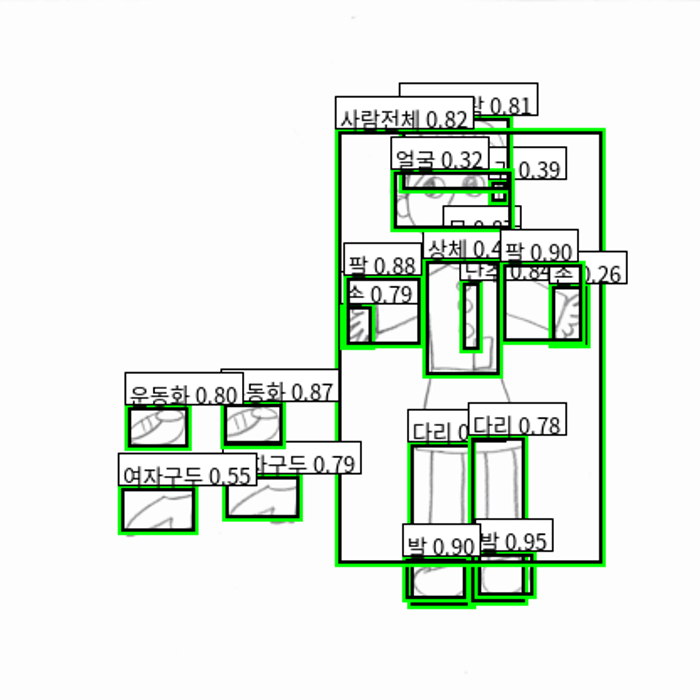

클래스: 귀, 점수: 0.391, 박스좌표: [290.1933288574219, 106.9642105102539, 302.4374084472656, 121.13488006591797]
클래스: 다리, 점수: 0.787, 박스좌표: [242.40650939941406, 262.2373962402344, 282.27508544921875, 361.6995544433594]
클래스: 다리, 점수: 0.781, 박스좌표: [278.66741943359375, 258.37115478515625, 313.95806884765625, 359.26959228515625]
클래스: 단추, 점수: 0.837, 박스좌표: [273.9239196777344, 166.8709716796875, 286.3752136230469, 209.45751953125]
클래스: 머리카락, 점수: 0.812, 박스좌표: [237.05210876464844, 68.5240707397461, 304.5534973144531, 114.51778411865234]
클래스: 목, 점수: 0.875, 박스좌표: [263.4037780761719, 140.09957885742188, 285.2544860839844, 156.29550170898438]
클래스: 발, 점수: 0.947, 박스좌표: [282.9988708496094, 327.3176574707031, 318.9363708496094, 355.8007507324219]
클래스: 발, 점수: 0.903, 박스좌표: [239.99343872070312, 330.4156188964844, 278.0998840332031, 357.0919494628906]
클래스: 사람전체, 점수: 0.823, 박스좌표: [199.5972900390625, 76.50119018554688, 359.00006103515625, 336.6150207519531]
클래스: 상체, 점수: 0.436, 박스좌표: [251.87203979492188, 153.702667236328

In [19]:
# 샘플 이미지 경로 (train_items, val_items 같은 리스트에서 하나 뽑아오기)
sample_img = train_items[100]["img_path"]   # dataset 로딩 코드에서 만든 train_items 사용

# 추론 및 시각화
drawn, (boxes, scores, labels) = infer_image(
    model,
    sample_img,
    conf_th=0.15,   # 낮추면 더 많은 박스 출력
    iou_th=0.45
)

# 화면에 크게 표시
drawn_resized = drawn.resize((700, 700))
display(drawn_resized)

# 박스/라벨 결과도 출력
for b, s, l in zip(boxes, scores, labels):
    print(f"클래스: {idx2cls[l]}, 점수: {s:.3f}, 박스좌표: {b}")

## 10) 배치 추론 & 저장

In [16]:
from pathlib import Path
# 결과 저장할 폴더 생성
out_dir = Path("./predictions_yolov2"); out_dir.mkdir(parents=True, exist_ok=True)

# 검증 데이터(val_items) 중 30장만 추론해서 저장
for it in val_items[:30]:
    img_p = it["img_path"] # 원본 이미지 경로
    drawn, _ = infer_image(model, img_p, conf_th=0.25, iou_th=0.45)  # YOLOv2 추론 + 시각화
    save_p = out_dir / (Path(img_p).stem + "_pred.jpg") # 저장 경로 지정
    drawn.save(save_p) # 결과 이미지 저장

print("Saved to:", out_dir.resolve()) # 저장 폴더 경로 출력

Saved to: /content/predictions_yolov2


In [24]:
# 1) 모델 초기화
model = YOLOv2(num_classes=num_classes, anchors=anchors_px, grid_size=GRID_SIZE).to(DEVICE)

# 2) 베스트 모델 불러오기
torch.serialization.add_safe_globals([ "numpy._core.multiarray._reconstruct" ])

checkpoint = torch.load("yolov2_drawings_best.pt", map_location=DEVICE, weights_only=False)
model.load_state_dict(checkpoint["model"])
model.eval()

# 3) JSON 저장
out_dir = Path("./predictions_json")
out_dir.mkdir(parents=True, exist_ok=True)

for it in val_items:
    img_p = it["img_path"]
    drawn, (boxes, scores, labels) = infer_image(model, img_p, conf_th=0.15, iou_th=0.45)

    detections = [{"class": idx2cls[l], "score": float(s), "bbox": [float(c) for c in b]}
                  for b, s, l in zip(boxes, scores, labels)]

    data = {"img_path": str(img_p), "detections": detections}

    json_path = out_dir / (Path(img_p).stem + ".json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

In [25]:
# folder = Path("predictions_json")

# # zip으로 압축
# shutil.make_archive("predictions_json", 'zip', folder)

# print("압축 완료! 'predictions_json.zip' 파일이 생성되었습니다.")

압축 완료! 'predictions_json.zip' 파일이 생성되었습니다.
